#Collect Wikipedia data about Olympic Games 2016

#1.1 Data extraction using the wikipedia API

In [3]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=394a3ad1623af91d92a6b8711f12319275e14ce34db0dadf57a67665e2cd2bb0
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [4]:

import pandas as pd
import wikipedia

####Get the titles which are related to Olympic games hosted in 2016, given a list of titles


In [5]:
def filter_olympic_2016_titles(titles):
  titles=[title for title in titles if '2016' in title and 'olympi' in title.lower()]
  return titles


####    Get the wikipedia page given a title


In [6]:
def get_wiki_page(title):
   a=1
   try:
    return wikipedia.page(title)
   except wikipedia.exceptions.DisambiguationError as e:
      print(e)
      return wikipedia.page(e.options[0])
   except wikipedia.exceptions.PageError as e:
      print(e)
      return None



####    Recursively find all the pages that are linked to the Wikipedia titles in the list


In [7]:
def recursively_find_all_page(titles,titles_so_far=set()):
  all_pages=[]

  titels=list(set(titles)-titles_so_far)
  titles=filter_olympic_2016_titles(titels)
  titles_so_far.update(titles)
  for title in titles:
    page=get_wiki_page(title)
    if page is None:
      continue
    all_pages.append(page)

    new_pages= recursively_find_all_page(page.links,titles_so_far)

    for pg in new_pages:
      if pg.title not in [p.title for p in all_pages]:
        all_pages.append(pg)
    titles_so_far.update([p.title for p in all_pages])
  return all_pages


In [8]:
pages=recursively_find_all_page(["2016 Summer Olympics"])
len(pages)

Page id "japan at the 2020 summer olympics" does not match any pages. Try another id!
Page id "2019 united states olympic trials track and field" does not match any pages. Try another id!
Page id "athletics at the 2012 summer olympics – women's high jump" does not match any pages. Try another id!
Page id "equestrian events at the 2020 summer olympics" does not match any pages. Try another id!
Page id "list of shooters at the 2018 summer olympics" does not match any pages. Try another id!
Page id "list of rovers at the 2017 summer olympics" does not match any pages. Try another id!
Page id "list of athletics at the 2016 summer olymics" does not match any pages. Try another id!
Page id "2019 fiba olympic marathon swim qualifier" does not match any pages. Try another id!
Page id "2020 olympics" does not match any pages. Try another id!
Page id "list of sailors at the 2018 summer olympics" does not match any pages. Try another id!
Page id "list of equestrian at the 2016 summer olymics" doe

822

In [9]:
total_page=pages
len(pages)

822

#Filtering the Wikipedia pages and splitting them into sections by headings

We remove sections unlikely to contain textual information, and ensure that each section is not longer than the token limit

In [11]:
import re
from typing import Set
from transformers import GPT2TokenizerFast

import numpy as np
from nltk.tokenize import sent_tokenize

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

#### count the number of tokens in a string"

In [12]:
def count_tokens(text:str)->int:
  return len(tokenizer.encode(text))

####  Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end

In [13]:
def reduce_long(long_text:str,long_text_tokens:bool=False,max_len:int=590)->str:
  if not long_text_tokens:
    long_text_tokens=count_tokens(long_text)
  if long_text_tokens>max_len:
    sentences=sent_tokenize(long_text.replace("\n",""))
    ntokens=0
    for i,sentence in enumerate(sentences):
      ntokens+=1+count_tokens(sentence)
      if ntokens>max_len:
        return " ".join(sentences[:i])
  return long_text



In [14]:
discard_categories=['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]

###    Extract the sections of a Wikipedia page, discarding the references and other low information sections


In [15]:
def extract_sections(wiki_text:str,title:str,max_len:int=1500,discard_categories:Set[str]=discard_categories)->str:

  if(len(wiki_text)==0):
    return []
      # find all headings and the corresponding contents

  headings=re.findall("==+ .* ==+",wiki_text)
  for heading in headings:
    wiki_text = wiki_text.replace(heading, "==+ !! ==+")

  contents=wiki_text.split(sep="==+ !! ==+")

  contents=[c.strip() for c in contents]
  assert  len(headings)==len(contents)-1

  cont=contents.pop(0).strip()

  outputs=[(title,"Summary",cont,count_tokens(cont)+4)]

      # discard the discard categories, accounting for a tree structure

  max_level=100

  keep_group_level=max_level

  remove_group_level=max_level

  nheadings,ncontents=[],[]

  for heading,content in zip(headings,contents):

    plain_heading=" ".join(heading.split(" ")[1:-1])

    num_equals=len(heading.split(" ")[0])

    if num_equals>remove_group_level:
      keep_group_level=max_level

    if num_equals>remove_group_level:
      if (
                num_equals <= keep_group_level
            ):
                continue
    keep_group_level = max_level
    if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
    nheadings.append(heading.replace("=", "").strip())
    ncontents.append(content)
    remove_group_level = max_level

    # count the tokens of each section

    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len)))
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]


    return outputs






##### Example page being processed into sections


In [35]:
france_page=get_wiki_page("France at the 2016 Summer Olympics")
france=extract_sections(france_page.content,france_page.title)

# Example section

france

[('France at the 2016 Summer Olympics',
  'Summary',
  'France competed at the 2016 Summer Olympics in Rio de Janeiro, Brazil, from 5 to 21 August 2016. French athletes had appeared in every Summer Olympic Games of the modern era, alongside Australia, Great Britain, and Greece. The French Olympic Committee sent its largest ever delegation in Olympic history outside of when it was the host nation, with a total of 401 athletes, 232 men and 169 women, competing in all sports, except field hockey.',
  91),
 ('France at the 2016 Summer Olympics',
  'Medallists',
  '* – Indicates the athlete competed in preliminaries but not the final',
  18)]

####We create a dataset and filter out any sections with fewer than 40 tokens, as those are unlikely to contain enough context to ask a good question.

In [17]:
# taken 600 pages from pages
pages=pages[:600]

In [22]:
res=[]
for page in pages:
  result=extract_sections(page.content,page.title)
  if result is not  None:
    res+=result

df=pd.DataFrame(res,columns=["title","heading","content","tokens"])
df.head()


Token indices sequence length is longer than the specified maximum sequence length for this model (1216 > 1024). Running this sequence through the model will result in indexing errors


,title,heading,content,tokens
0,2020 Summer Olympics,Summary,"The 2020 Summer Olympics, officially the Games...",624
1,2020 Summer Olympics,Bidding process,"The three candidate cities were Tokyo, Istanbu...",38
2,2016 Winter Youth Olympics,Summary,The 2016 Winter Youth Olympics (Norwegian: Oly...,152
3,2016 Winter Youth Olympics,Host selection,Lillehammer was the only city to bid for the g...,129
4,Cross-country skiing at the 2016 Winter Youth ...,Summary,The boys' cross-country cross freestyle cross-...,48


In [24]:
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])

df.head()

,title,heading,content,tokens
0,2020 Summer Olympics,Summary,"The 2020 Summer Olympics, officially the Games...",624
2,2016 Winter Youth Olympics,Summary,The 2016 Winter Youth Olympics (Norwegian: Oly...,152
3,2016 Winter Youth Olympics,Host selection,Lillehammer was the only city to bid for the g...,129
4,Cross-country skiing at the 2016 Winter Youth ...,Summary,The boys' cross-country cross freestyle cross-...,48
6,Cross-country skiing at the 2016 Winter Youth ...,Summary,The girls' sprint classical cross-country skii...,44


In [25]:
len(df)

755

##### reset index

In [26]:
df=df.reset_index().drop('index',axis=1)
df.head()

,title,heading,content,tokens
0,2020 Summer Olympics,Summary,"The 2020 Summer Olympics, officially the Games...",624
1,2016 Winter Youth Olympics,Summary,The 2016 Winter Youth Olympics (Norwegian: Oly...,152
2,2016 Winter Youth Olympics,Host selection,Lillehammer was the only city to bid for the g...,129
3,Cross-country skiing at the 2016 Winter Youth ...,Summary,The boys' cross-country cross freestyle cross-...,48
4,Cross-country skiing at the 2016 Winter Youth ...,Summary,The girls' sprint classical cross-country skii...,44


In [27]:
len(df)

755

#### Save the section dataset
We will save the section dataset, for the next notebook

In [28]:
df.to_csv('olympics_sections_600.csv', index=False)



###1.3 (Optional) Exploring the data


In [29]:
df.title.value_counts().head()

title
Synchronized swimming at the 2016 Summer Olympics – Women's duet    2
Kosovo at the 2016 Summer Olympics                                  2
Water polo at the 2016 Summer Olympics – Men's qualification        2
Athletics at the 2016 Summer Olympics – Men's hammer throw          2
Tuvalu at the 2016 Summer Olympics                                  2
Name: count, dtype: int64

There appear to be winter and summer Olympics 2020. We chose to leave a little ambiguity and noise in the dataset, even though we were interested in only Summer Olympics 2020.

In [30]:
df.title.str.contains('Summer').value_counts()

title
True     697
False     58
Name: count, dtype: int64

In [31]:
df.title.str.contains('Winter').value_counts()

title
False    750
True       5
Name: count, dtype: int64

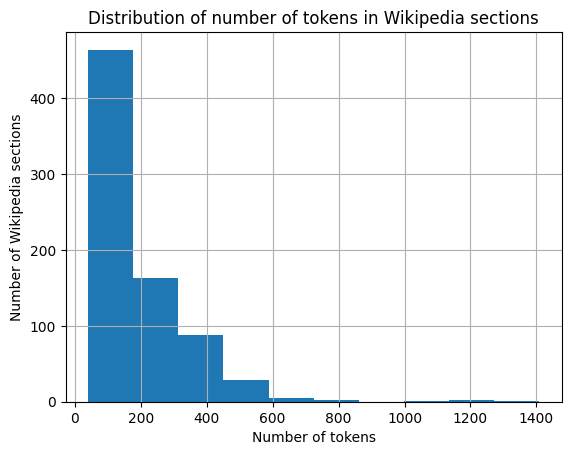

In [32]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('olympics_sections_600.csv')
df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()